Text(0, 0.5, 'CL')

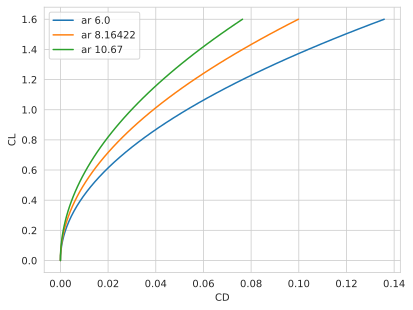

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np 
import matplotlib.pyplot as plt
from numpy import newaxis as na
import seaborn as sns
from parse_openvsp import get_polar
import pandas as pd

sns.set_style(style="whitegrid")

cl = np.linspace(0, 1.6)
ar = np.array([6, 8.16422, 10.67])
cd = (cl**2)[:, na] / (np.pi * ar[na, :])
for i in range(len(ar)):
    plt.plot(cd[:, i], cl, label="ar " + str(ar[i]))
plt.legend()
plt.xlabel("CD")
plt.ylabel("CL")

Calculated K 0.04643007685784312
Calculated cd0 0.007570923585883821
Theoretical K 0.03898840136397484
Oswald efficiency 0.839722955517546


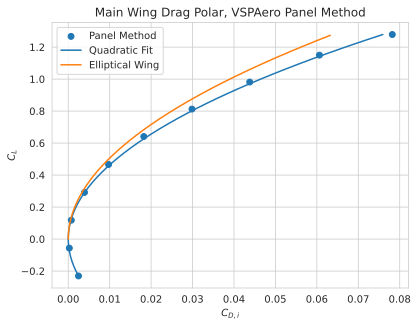

In [2]:
res = get_polar('resources/main_wing_a-3_a14_10pts_panel.csv')
alpha = np.array(list(map(float, res['Alpha'])))
CDi = np.array(list(map(float, res['CDtott'])))
CL = np.array(list(map(float, res['CL'])))
K, _, cd0 = np.polyfit(CL[:-1], CDi[:-1], 2)
CL_linspace = np.linspace(CL[0], CL[-1])
CDi_fit = K * CL_linspace**2 + cd0
plt.scatter(CDi - cd0, CL, label="Panel Method")
plt.plot(CDi_fit - cd0, CL_linspace, label="Quadratic Fit")
plt.plot(cd[:-10, 1], cl[:-10], label="Elliptical Wing")
plt.ylabel(r"$C_L$")
plt.xlabel(r"$C_{D,i}$")
plt.title("Main Wing Drag Polar, VSPAero Panel Method")
plt.legend()
K_theory = 1/ np.pi / ar[1] 
print("Calculated K", K)
print("Calculated cd0", cd0)
print("Theoretical K", K_theory)
eff = K_theory / K
print("Oswald efficiency", K_theory / K)
plt.savefig("figures/main_wing_panel.svg")

In [3]:
# plt.plot(alpha, CL)
print(np.polyfit(np.radians(alpha), CL, 1))

[5.16308786 0.04960792]


Calculated K 0.05137621279275726
Calculated cd0 0.00844445258223399
Theoretical K 0.04897075172058318
Oswald efficiency 0.9531794785676926


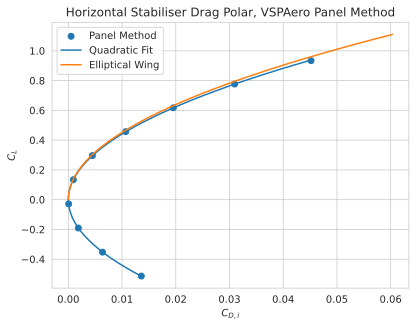

In [4]:
res = get_polar('resources/h_stab_a-3_a14_10pts_panel.csv')
AR = 6.5
K_theory = 1/np.pi / AR
alpha = np.array(list(map(float, res['Alpha'])))
CDi = np.array(list(map(float, res['CDtott']))) * 1.5/0.26
CL = np.array(list(map(float, res['CL']))) * 1.5/0.26
K, _, cd0 = np.polyfit(CL[:-1], CDi[:-1], 2)
CL_linspace = np.linspace(CL[0], CL[-1])
CDi_fit = K * CL_linspace**2 + cd0
plt.scatter(CDi - cd0, CL, label="Panel Method")
plt.plot(CDi_fit - cd0, CL_linspace, label="Quadratic Fit")
plt.plot(cl[:-15]**2 * K_theory, cl[:-15], label="Elliptical Wing")
plt.ylabel(r"$C_L$")
plt.xlabel(r"$C_{D,i}$")
plt.title("Horizontal Stabiliser Drag Polar, VSPAero Panel Method")
plt.legend()
print("Calculated K", K)
print("Calculated cd0", cd0)
print("Theoretical K", K_theory)
eff = K_theory / K
print("Oswald efficiency", K_theory / K)
plt.savefig("figures/hstab_panel.svg")

In [5]:
print(np.polyfit(np.radians(alpha - 3), CL, 1))

[ 4.88794000e+00 -4.34650938e-04]


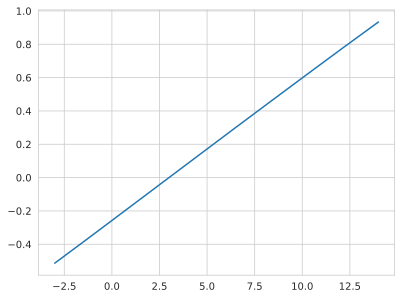

In [6]:
plt.plot(alpha, CL)

In [7]:
res.keys()

dict_keys(['Results_Name', 'Results_Timestamp', 'Results_Date', 'Results_Time', 'Alpha', 'Beta', 'CDi', 'CDo', 'CDt', 'CDtot', 'CDtott', 'CFx', 'CFy', 'CFz', 'CL', 'CMl', 'CMm', 'CMn', 'CMx', 'CMy', 'CMz', 'CS', 'E', 'Fopt', 'L_D', 'Mach', 'Re_1e6'])

CL_h_delta: 2.97214523319904
X/c neutral point: 0.5429428491703233
Lift moment:
 [[0.         0.09350613 0.18701226]]
Tail lift coefficient:
 [[-0.27436873  0.03274959  0.33986792]
 [-0.17062129  0.13649703  0.44361536]
 [-0.06687385  0.24024447  0.5473628 ]]
Tail moment:
 [[ 0.14663384 -0.01750272 -0.18163928]
 [ 0.09118698 -0.07294958 -0.23708614]
 [ 0.03574011 -0.12839645 -0.29253301]]


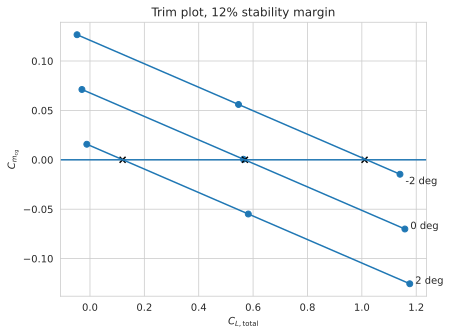

In [8]:
# trim calculations
# static stability requires a balance of forces and moments
# we need the lift curve slope for the main wing and the horizontal tail
# tail lift curve slope:
from numpy import newaxis as na

CL_0 = 0
CL_h_0 = 0
i_h = np.radians(-2)
CL_h_alpha = 4.88794
CL_w_alpha = 5.16308

def Delta_alpha_0L(cf, c):
    # empirical correlation
    l = cf / c
    return 1.576 * l**3 - 3.458 * l**2 + 2.882 * l

da0l = Delta_alpha_0L(62, 200)
CL_h_delta = CL_h_alpha * da0l
print("CL_h_delta:", CL_h_delta)
# moment coefficient for the random airfoil that we're going with 
CM_w = -0.02
S_h = 0.2 * 1.3
S_w = 1.5
cbar = 0.4287
Xbar_acw = 0.25
Xbar_ach = (1.6 + 0.2 * 0.25) / cbar
# downwash effects
eps_alpha = 0.4 # between 0.3 and 0.4, Raymer

def C_M_cg(Xbar_cg, delta_h, alpha):
    # distances taken to the leading edge of the wing
    CL = CL_0 + CL_w_alpha * alpha
    alpha_h = alpha * (1 - eps_alpha) + i_h + da0l * delta_h
    CL_h = CL_h_alpha * alpha_h
    eta_h = 0.9
    lift_moment = CL * (Xbar_cg - Xbar_acw) 
    wing_moment = CM_w
    tail_moment = - eta_h * S_h / S_w * CL_h * (Xbar_ach - Xbar_cg)
    print("Lift moment:\n", lift_moment)
    print("Tail lift coefficient:\n", CL_h)
    print("Tail moment:\n", tail_moment)
    return lift_moment + wing_moment + tail_moment, CL + CL_h * S_h / S_w

def Xbar_np():
    # CL = CL_0 + CL_w_alpha * alpha
    # alpha_h = alpha * (1 - eps_alpha) + i_h + da0l * delta_h
    # CL_h = CL_h_alpha * alpha_h
    eta_h = 0.9
    d_CLh_dalpha = CL_h_alpha * (1 - eps_alpha)
    numerator =  CL_w_alpha * Xbar_acw + eta_h * S_h / S_w * d_CLh_dalpha * Xbar_ach
    denominator = CL_w_alpha + eta_h * S_h / S_w * d_CLh_dalpha
    return numerator/denominator

print("X/c neutral point:", Xbar_np())

alpha = np.radians(np.array([0., 6., 12.]))
delta_h = np.radians(np.array([-2., 0., 2.]))

Xbar_cg = Xbar_np() - 0.12

C_Ms, C_Ls = C_M_cg(Xbar_cg, delta_h[:, na], alpha[na, :])

plt.scatter(C_Ls, C_Ms)
for i in range(len(delta_h)):
    plt.plot(C_Ls[i, :], C_Ms[i, :], color="C0")
plt.scatter(np.array([0.12, 0.57, 1.01]), np.zeros(3), marker="x", color="k", label="Trim points")
plt.axhline(0)
plt.annotate("-2 deg", xy=(C_Ls[0, -1] + .02, C_Ms[0, -1] - .01))
plt.annotate("0 deg", xy=(C_Ls[1, -1] + .02, C_Ms[1, -1]))
plt.annotate("2 deg", xy=(C_Ls[2, -1] + .02, C_Ms[2, -1]))
# plt.annotate("3 deg", xy=(C_Ls[3, -1] + .02, C_Ms[3, -1]))

plt.ylabel(r"$C_{m_\text{cg}}$")
plt.xlabel(r"$C_{L, \text{total}}$")
plt.title("Trim plot, 12% stability margin")
plt.tight_layout()

In [9]:
print(5.16308 * np.radians(9))
print(1.6 * np.tan(np.radians(9)) / 1.75)

0.8110147098948194
0.14480863115386172


In [10]:
Xbar_cg * cbar

0.18131559943931763

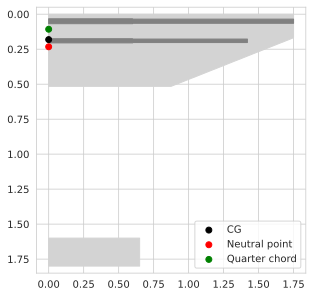

In [28]:
wing_x = np.array([0., 1.75, 1.75, 0.875, 0., 0.])
wing_y = np.array([0., 0., 0.168, 0.5154, 0.5154, 0.])
tail_x = np.array([0., 0.65, 0.65, 0., 0.])
tail_y = np.array([0., 0., 0.2, 0.2, 0.]) + 1.6

d = 140e-3 # center spacing
r_1 = 35e-3/2
r_2 = 30e-3/2
r_3 = 25e-3/2
x_c_1 = 50e-3
x_c_2 = x_c_1 + d

x_tubes = np.array([0, 0.6, 0.6, 1.75, 1.75, 0.6, 0.6, 0, 0])
x_tubes_short = np.array([0, 0.6, 0.6, 1.42, 1.42, 0.6, 0.6, 0, 0])
y_1 = x_c_1 * np.ones_like(x_tubes) + \
    np.array([-r_1, -r_1, -r_2, -r_2, r_2, r_2, r_1, r_1, -r_1])
y_2 = x_c_2 * np.ones_like(x_tubes) + \
    np.array([-r_2, -r_2, -r_3, -r_3, r_3, r_3, r_2, r_2, -r_2])

plt.fill(wing_x, wing_y, color="lightgray")
plt.fill(tail_x, tail_y, color="lightgray")

plt.fill(x_tubes, y_1, color="gray")
plt.fill(x_tubes_short, y_2, color="gray")

plt.scatter(0, Xbar_cg * cbar, color="k", label="CG")
plt.scatter(0, Xbar_np() * cbar, color="r", label="Neutral point")
plt.scatter(0, 0.25 * cbar, color="g", label="Quarter chord")
plt.ylim(1.85, -0.05)
plt.gca().set_aspect("equal")
plt.legend()